# Restricted Boltzmann Machine using quantum annealing on D-wave's QPU

## Imports

In [1]:
import numpy as np
import timeit
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

from qrbm.EncodedQRBM import QRBM

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'gray'

import pandas as pd

from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
from skimage import img_as_bool

import cv2 as cv

import random

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Presets

Here you can set hyperparameters for learning:

 - digits: list of digits to train on
 - THRESHOLD: how bright parts of image become 1 (darker become 0)
 - n_hidden: number of neurons in hidden layer
 - qpu: whether to use real D-wave's qpu (requires [setup](https://docs.ocean.dwavesys.com/en/stable/overview/sapi.html)) or a local simulator
 - epochs: number of epochs
 - lr: learning rate


In [2]:
n_hidden = 50
qpu = True
epochs = 50
lr = 0.1

## reading dataset

In [3]:
data = pd.read_csv('encoded_data.csv')

## prepare train and test set

In [4]:
data[:10]

,Sex,Stoke Risk (ABCD2 > 4),Dizziness Type,Triggered by turning in bed?,SG Vertical N-None,SG Vertical N-Down-beating_vs_Up-beating,SG Horizintal N-None,SG Horizintal N-Left-beating_vs_Right-beating,SG Torsional N-None,SG Torsional N-Top-pole-to-L-ear torsional_vs_Top-pole-to-R-ear torsional,...,Alternate Cover (Moving from Left Eye Occluded to Right Eye Occluded) caused horizontal-L eye moves up (L hyper)_vs_R eye moves down (R hyper),Head impulse test to the left showed,Head impulse test to the right showed,Gait,Finger-nose-finger left hand-Abnormal,Finger-nose-finger left hand-None_vs_Normal,Finger-nose-finger right hand-Abnormal,Finger-nose-finger right hand-None_vs_Normal,Hearing loss right ear,Hearing loss left ear
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,-1,1,-1,1,1
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,-1,1,-1,1,1
2,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,-1,1,-1,1,1
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,-1,1,-1,1,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,-1,1,-1,1,1
5,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,-1,1,-1,1,1
6,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,-1,1,-1,1,1
7,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,-1,1,-1,1,1
8,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,-1,1,-1,1,1
9,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,-1,1,-1,1,1


In [5]:
indices = list(range(len(data)))
random.shuffle(indices)

In [6]:
len(indices)

95

In [7]:
num_train = int(len(data) * .9)
train = indices[:num_train]
test = indices[num_train:]
print(len(train), len(test))

85 10


In [8]:
X_train = data.values[train]
X_test = data.values[test]

In [9]:
X_train.shape

(85, 76)

## training

In [10]:
# import tracemalloc 
  
# tracemalloc.start() 

bm = QRBM(X_train[0], n_hidden=n_hidden, qpu=qpu)
bm.tqdm = tqdm

  0%|          | 0/50 [00:00<?, ?it/s]

0
10


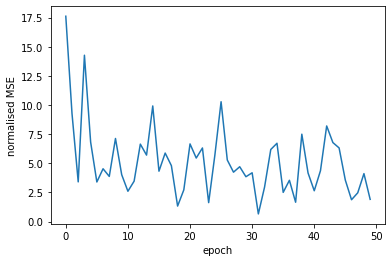

In [11]:
bm.train(X_train, epochs = epochs, lr = lr, lr_decay = 0.1)

# snapshot = tracemalloc.take_snapshot() 
# top_stats = snapshot.statistics('lineno') 
  
# for stat in top_stats[:10]: 
#    print(stat)

# Load raw dat

In [16]:
from parsing_data import load_data, clean_data, load_config

config_file = 'config.json'
data_file = 'Simplified Dataset.xlsx'
sheet = 'Copy of Cases-Use'

config = load_config(config_file)
raw_data = load_data(data_file, sheet)
df = clean_data(raw_data, config)

Data has 95 rows and 54 columns.
Creating mask to determine which rows can be dropped
Currently 0 rows are being dropped
Checking for entries that are droppable by being rare...
0 rows are being dropped
Checking for unknown values that require warnings...
Checking for columns that lack signal...
Data has 95 rows and 54 columns.


In [17]:
df['Disease']

0     BPPV (PC) R
1     BPPV (PC) L
2     BPPV (PC) L
3     BPPV (PC) R
4     BPPV (PC) R
         ...     
90         Stroke
91         Stroke
92         Stroke
93         Stroke
94         Stroke
Name: Disease, Length: 95, dtype: object

## Encoder

In [18]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, TargetEncoder

encoder = OrdinalEncoder().fit(df[['Disease']])

In [19]:
y = encoder.transform(df[['Disease']])

In [20]:
y_train = y.ravel()[train]
y_test = y.ravel()[test]

In [21]:
y_test

array([4., 1., 1., 2., 4., 5., 5., 4., 4., 4.])

# Train a multi-class classifier

## Compile the training data

In [22]:
X_test.shape

(10, 76)

In [23]:
X_train[0]

array([ 0,  0,  1,  1,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,
        0,  1,  1,  0,  0,  0,  0,  1,  0,  1,  0,  0,  1,  0,  0,  0,  0,
        0,  1,  0,  0,  0,  0,  0,  1, -1,  0,  0,  0,  0,  1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  1,  0,  1,
        0,  0,  1, -1,  1, -1,  1,  1])

In [26]:
encoded_train = np.array([bm.sample_hidden(x) for x in X_train])
encoded_test = np.array([bm.sample_hidden(x) for x in X_test])

In [27]:
encoded_train.shape

(85, 50)

In [28]:
y_train.shape

(85,)

## Train a model

In [29]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0)

clf = clf.fit(encoded_train, y_train)

In [30]:
encoder.inverse_transform(np.array([[6.]]))

array([['Vestibular Neuritis R']], dtype=object)

In [31]:
g = 0
b = 0
for x, y in zip(encoded_test, y_test.tolist()):
    x = x.reshape(1, -1)
    y = np.array([[y]])
    print(encoder.inverse_transform(y))
    pred_indx = clf.predict(x)
    y_est = pred_indx.reshape((1, 1))
    print(encoder.inverse_transform(y_est), pred_indx)
    if y == y_est:
        g += 1
    else:
        b += 1
    print(clf.predict_proba(x))
    print(clf.score(x, y))
    print('===')
print(g, b, g/(g+b))

[['Stroke']]
[['Stroke']] [4.]
[[0.00235359 0.00273424 0.01902502 0.01240163 0.95813286 0.00152153
  0.00383112]]
1.0
===
[['BPPV (HC) R']]
[['BPPV (HC) R']] [1.]
[[0.25943161 0.57638271 0.02838741 0.03420375 0.04189771 0.03610004
  0.02359678]]
1.0
===
[['BPPV (HC) R']]
[['BPPV (HC) L']] [0.]
[[0.39377541 0.30714618 0.02896548 0.01416426 0.21751309 0.02740455
  0.01103102]]
0.0
===
[['BPPV (PC) L']]
[['BPPV (PC) L']] [2.]
[[0.01663718 0.0143994  0.77663189 0.13665732 0.03683247 0.01128171
  0.00756002]]
1.0
===
[['Stroke']]
[['Stroke']] [4.]
[[5.48801537e-04 9.04686890e-04 1.29192480e-03 5.09478370e-03
  9.90899648e-01 1.62576751e-04 1.09757828e-03]]
1.0
===
[['Vestibular Neuritis L']]
[['Vestibular Neuritis L']] [5.]
[[0.04085003 0.02778818 0.01278251 0.00696172 0.15826548 0.73428459
  0.01906751]]
1.0
===
[['Vestibular Neuritis L']]
[['Vestibular Neuritis L']] [5.]
[[0.02589527 0.01768724 0.00529877 0.01123982 0.29097365 0.63744925
  0.011456  ]]
1.0
===
[['Stroke']]
[['Stroke']] [4

In [32]:
g = 0
b = 0
for x, y in zip(encoded_train, y_train.tolist()):
    x = x.reshape(1, -1)
    y = np.array([[y]])
    print(encoder.inverse_transform(y))
    pred_indx = clf.predict(x)
    y_est = pred_indx.reshape((1, 1))
    print(encoder.inverse_transform(y_est), pred_indx)
    if y == y_est:
        g += 1
    else:
        b += 1
    print(clf.predict_proba(x))
    print(clf.score(x, y))
    print('===')
print(g, b, g/(g+b))

[['Stroke']]
[['Stroke']] [4.]
[[0.00878202 0.00286738 0.00104342 0.00174449 0.97678358 0.00256539
  0.00621372]]
1.0
===
[['BPPV (HC) L']]
[['BPPV (HC) L']] [0.]
[[0.50586901 0.31187084 0.05267682 0.03981707 0.03696206 0.04212153
  0.01068267]]
1.0
===
[['Stroke']]
[['Stroke']] [4.]
[[0.06447345 0.01834486 0.00420684 0.00858639 0.84605413 0.05245723
  0.0058771 ]]
1.0
===
[['Vestibular Neuritis L']]
[['Vestibular Neuritis L']] [5.]
[[0.04085003 0.02778818 0.01278251 0.00696172 0.15826548 0.73428459
  0.01906751]]
1.0
===
[['Stroke']]
[['Stroke']] [4.]
[[3.19742185e-04 7.73776117e-04 1.06130336e-03 6.12729959e-03
  9.91279888e-01 3.15434170e-04 1.22556744e-04]]
1.0
===
[['BPPV (PC) R']]
[['BPPV (PC) R']] [3.]
[[0.0106737  0.0077381  0.04230071 0.88822384 0.0418365  0.00539609
  0.00383106]]
1.0
===
[['Stroke']]
[['Stroke']] [4.]
[[0.00151725 0.00337314 0.00341552 0.00558851 0.97842565 0.00571792
  0.001962  ]]
1.0
===
[['BPPV (PC) R']]
[['BPPV (PC) R']] [3.]
[[0.00776338 0.01129805 0.1

In [33]:
clf.score(encoded_test, y_test)

0.9

In [34]:
clf.score(encoded_train, y_train)

0.9882352941176471

# All in one

Data has 95 rows and 54 columns.
Creating mask to determine which rows can be dropped
Currently 0 rows are being dropped
Checking for entries that are droppable by being rare...
0 rows are being dropped
Checking for unknown values that require warnings...
Checking for columns that lack signal...
Data has 95 rows and 54 columns.


  0%|          | 0/30 [00:00<?, ?it/s]

0
7


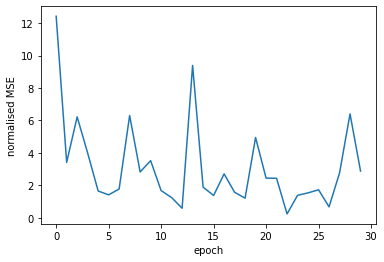

[['BPPV (HC) R']] [['BPPV (HC) L']]
18 1 0.9473684210526315


  0%|          | 0/30 [00:00<?, ?it/s]

0
58


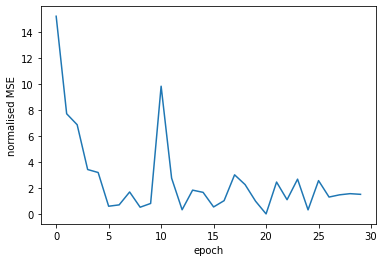

[['BPPV (HC) L']] [['BPPV (HC) R']]
18 1 0.9473684210526315


  0%|          | 0/30 [00:00<?, ?it/s]

0
20


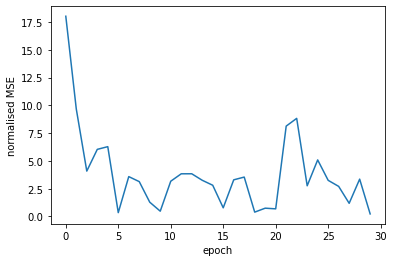

[['BPPV (HC) L']] [['BPPV (HC) R']]
18 1 0.9473684210526315


  0%|          | 0/30 [00:00<?, ?it/s]

0
59


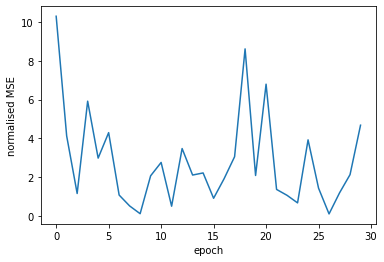

[['BPPV (HC) R']] [['BPPV (HC) L']]
[['BPPV (HC) R']] [['Stroke']]
[['BPPV (HC) R']] [['BPPV (HC) L']]
16 3 0.8421052631578947


  0%|          | 0/30 [00:00<?, ?it/s]

0
1


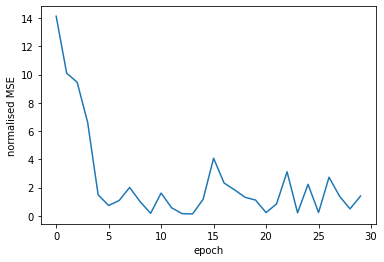

[['BPPV (HC) R']] [['BPPV (HC) L']]
18 1 0.9473684210526315
0.9263157894736842


<Figure size 432x288 with 0 Axes>

In [127]:
%run model_training.py

# Feature Importance

In [35]:
import pickle

In [36]:
with open('encoding_col_map.pkl', 'rb') as f:
    col_map = pickle.load(f)

In [37]:
col_map

{'Sex': {'indx': [0], 'columns': ['Sex']},
 'Stoke Risk (ABCD2 > 4)': {'indx': [1],
  'columns': ['Stoke Risk (ABCD2 > 4)']},
 'Dizziness Type': {'indx': [2], 'columns': ['Dizziness Type']},
 'Triggered by turning in bed?': {'indx': [3],
  'columns': ['Triggered by turning in bed?']},
 'SG Vertical N': {'indx': [4, 5],
  'columns': ['SG Vertical N-None',
   'SG Vertical N-Down-beating_vs_Up-beating']},
 'SG Horizintal N': {'indx': [6, 7],
  'columns': ['SG Horizintal N-None',
   'SG Horizintal N-Left-beating_vs_Right-beating']},
 'SG Torsional N': {'indx': [8, 9],
  'columns': ['SG Torsional N-None',
   'SG Torsional N-Top-pole-to-L-ear torsional_vs_Top-pole-to-R-ear torsional']},
 'Right Gaze Vertical N': {'indx': [10], 'columns': ['Right Gaze Vertical N']},
 'Right G Horizintal N': {'indx': [11], 'columns': ['Right G Horizintal N']},
 'Right G Torsional N': {'indx': [12, 13],
  'columns': ['Right G Torsional N-None',
   'Right G Torsional N-Top-pole-to-L-ear torsional_vs_Top-pole-to-

In [96]:
def relative_feature_importance(values):
    r = 20
    rescale_max = 0.2
    values = 2*np.arccos(values)/np.pi
    print(values)
    print(np.max(values), np.min(values))
    center = ((np.max(values) + np.min(values))/2)
    print(center)
    values = values - center
    print(values)
    low = np.min(values)
    high = np.max(values)
    print(high, low, high-low)
    values = (values / max(rescale_max, (high-low))) + .5
    print(np.max(values), np.min(values))
    print(values)
    print((r**(values) - 1)/(r-1))
    return (r**(values) - 1)/(r-1)

In [101]:
indx = 5
for _ in range(5):
    x = np.array([bm.sample_hidden(X_test[indx])])
    baseline = clf.predict_proba(x)
    print(np.round(baseline, 2))
    pred_indx = clf.predict(x)
    y_est = pred_indx.reshape((1, 1))
    print(encoder.inverse_transform(y_test[indx].reshape(1, -1)), encoder.inverse_transform(y_est), pred_indx)

y_ests = []
d_prods = []
probs = []
for col in col_map:
    mask = [False] * X_train.shape[1]
    for i in col_map[col]['indx']:
        mask[i] = True
    hidden = np.array([bm.sample_hidden(X_test[indx], mask=mask, use_visible=False)])
    masked_probs = clf.predict_proba(hidden)
    pred_indx = clf.predict(hidden)
    y_ests.append(pred_indx.reshape((1, 1)))
    d_prods.append(np.dot(baseline, masked_probs.T)[0, 0])
    probs.append(masked_probs)

d_prods2 = relative_feature_importance(np.array(d_prods))

for col, y_est, d_prod, d2, masked_probs in zip(col_map, y_ests, d_prods, d_prods2, probs):
    print('{:26s} \t {:20s} \t'.format(col[:28], encoder.inverse_transform(y_est)[0, 0]), np.round(d_prod, 5), '\t', np.round(d2, 5), '\t', np.round(masked_probs, 2))

[[0.04 0.03 0.01 0.01 0.16 0.73 0.02]]
[['Vestibular Neuritis L']] [['Vestibular Neuritis L']] [5.]
[[0.04 0.03 0.01 0.01 0.16 0.73 0.02]]
[['Vestibular Neuritis L']] [['Vestibular Neuritis L']] [5.]
[[0.04 0.03 0.01 0.01 0.16 0.73 0.02]]
[['Vestibular Neuritis L']] [['Vestibular Neuritis L']] [5.]
[[0.04 0.03 0.01 0.01 0.16 0.73 0.02]]
[['Vestibular Neuritis L']] [['Vestibular Neuritis L']] [5.]
[[0.04 0.03 0.01 0.01 0.16 0.73 0.02]]
[['Vestibular Neuritis L']] [['Vestibular Neuritis L']] [5.]
[0.65481564 0.61602381 0.68344617 0.7476419  0.61602381 0.73210737
 0.61602381 0.61602381 0.61602381 0.61602381 0.61602381 0.61602381
 0.61602381 0.62026441 0.69659803 0.61602381 0.61602381 0.76187554
 0.69659803 0.61602381 0.8134058  0.61602381 0.61602381 0.5666463
 0.61602381 0.61602381 0.74905274 0.61602381 0.61602381 0.61602381
 0.61602381 0.61602381 0.69782755 0.61602381 0.61602381 0.65481564
 0.61602381 0.61602381 0.61602381 0.61602381 0.58023878 0.57905345
 0.5666463  0.53089457 0.5308945

In [99]:
for indx in range(len(test)):
    for _ in range(5):
        x = np.array([bm.sample_hidden(X_test[indx])])
        baseline = clf.predict_proba(x)
        print(np.round(baseline, 2))
        pred_indx = clf.predict(x)
        y_est = pred_indx.reshape((1, 1))
        print(encoder.inverse_transform(y_test[indx].reshape(1, -1)), encoder.inverse_transform(y_est), pred_indx)

    y_ests = []
    d_prods = []
    probs = []
    for col in col_map:
        mask = [False] * X_train.shape[1]
        for i in col_map[col]['indx']:
            mask[i] = True
        hidden = np.array([bm.sample_hidden(X_test[indx], mask=mask, use_visible=False)])
        masked_probs = clf.predict_proba(hidden)
        pred_indx = clf.predict(hidden)
        y_ests.append(pred_indx.reshape((1, 1)))
        d_prods.append(np.dot(baseline, masked_probs.T)[0, 0])
        probs.append(masked_probs)

    d_prods2 = relative_feature_importance(np.array(d_prods))

    for col, y_est, d_prod, d2, masked_probs in zip(col_map, y_ests, d_prods, d_prods2, probs):
        print('{:26s} \t {:20s} \t'.format(col[:28], encoder.inverse_transform(y_est)[0, 0]), np.round(d_prod, 5), '\t', np.round(d2, 5), '\t', np.round(masked_probs, 2))

[[0.   0.   0.02 0.01 0.96 0.   0.  ]]
[['Stroke']] [['Stroke']] [4.]
[[0.   0.   0.02 0.01 0.96 0.   0.  ]]
[['Stroke']] [['Stroke']] [4.]
[[0.   0.   0.02 0.01 0.96 0.   0.  ]]
[['Stroke']] [['Stroke']] [4.]
[[0.   0.   0.02 0.01 0.96 0.   0.  ]]
[['Stroke']] [['Stroke']] [4.]
[[0.   0.   0.02 0.01 0.96 0.   0.  ]]
[['Stroke']] [['Stroke']] [4.]
[0.25869898 0.25869898 0.45714238 0.25370389 0.2635879  0.25869898
 0.30915824 0.23032457 0.2262684  0.21956069 0.25430677 0.25869898
 0.24806327 0.25869898 0.25869898 0.35167572 0.2702719  0.25869898
 0.25869898 0.27584499 0.25869898 0.27975113 0.24444762 0.25869898
 0.25579236 0.26447827 0.25869898 0.28533775 0.26447827 0.25869898
 0.39328062 0.2635399  0.25869898 0.2174339  0.22593596 0.25869898
 0.26670749 0.27584499 0.26899156 0.25869898 0.25869898 0.25869898
 0.22597834 0.23615868 0.23032457 0.24957594]
0.45714238244894057 0.2174339014940353
0.33728814197148793
[-0.07858916 -0.07858916  0.11985424 -0.08358425 -0.07370024 -0.07858916
 -0

[0.80694597 0.81413217 0.80694597 0.80694597 0.80694597 0.80694597
 0.80694597 0.80694597 0.81413217 0.80694597 0.80694597 0.80694597
 0.80694597 0.79236032 0.80694597 0.80694597 0.80694597 0.80694597
 0.83961441 0.80694597 0.80257051 0.80694597 0.80694597 0.80694597
 0.80694597 0.80694597 0.79672428 0.80694597 0.80694597 0.80694597
 0.80694597 0.80694597 0.80556877 0.80694597 0.80694597 0.79855141
 0.80694597 0.80694597 0.80694597 0.80694597 0.80694597 0.80694597
 0.80694597 0.80807639 0.81562241 0.80556877]
0.8396144090293327 0.7923603203129652
0.815987364671149
[-0.0090414  -0.00185519 -0.0090414  -0.0090414  -0.0090414  -0.0090414
 -0.0090414  -0.0090414  -0.00185519 -0.0090414  -0.0090414  -0.0090414
 -0.0090414  -0.02362704 -0.0090414  -0.0090414  -0.0090414  -0.0090414
  0.02362704 -0.0090414  -0.01341685 -0.0090414  -0.0090414  -0.0090414
 -0.0090414  -0.0090414  -0.01926309 -0.0090414  -0.0090414  -0.0090414
 -0.0090414  -0.0090414  -0.0104186  -0.0090414  -0.0090414  -0.01743

[0.12126798 0.12126798 0.13164807 0.12126798 0.12915181 0.12126798
 0.13192999 0.12446455 0.1241515  0.12915181 0.11324294 0.12126798
 0.13298248 0.12126798 0.12126798 0.12126798 0.13611188 0.12126798
 0.11324294 0.13452951 0.12126798 0.11324294 0.13919258 0.12126798
 0.12697792 0.14945739 0.12126798 0.15932353 0.12301271 0.12126798
 0.12027242 0.12126798 0.12126798 0.12126798 0.12126798 0.12126798
 0.12126798 0.15391378 0.16173316 0.12126798 0.12126798 0.12126798
 0.13452951 0.12126798 0.11585917 0.16173316]
0.161733162208161 0.11324293522323886
0.13748804871569992
[-0.01622007 -0.01622007 -0.00583998 -0.01622007 -0.00833623 -0.01622007
 -0.00555806 -0.0130235  -0.01333655 -0.00833623 -0.02424511 -0.01622007
 -0.00450557 -0.01622007 -0.01622007 -0.01622007 -0.00137617 -0.01622007
 -0.02424511 -0.00295854 -0.01622007 -0.02424511  0.00170453 -0.01622007
 -0.01051013  0.01196934 -0.01622007  0.02183548 -0.01447533 -0.01622007
 -0.01721563 -0.01622007 -0.01622007 -0.01622007 -0.01622007 -

[0.67232995 0.67232995 0.67232995 0.70069215 0.67232995 0.79985771
 0.67232995 0.67232995 0.67232995 0.67232995 0.67232995 0.67232995
 0.67232995 0.624559   0.75411547 0.67232995 0.67232995 0.76625817
 0.624559   0.67232995 0.78238832 0.67232995 0.67232995 0.59699247
 0.67232995 0.67232995 0.70168951 0.67232995 0.67232995 0.59699247
 0.67232995 0.67232995 0.75494357 0.67232995 0.67232995 0.75548573
 0.67232995 0.67232995 0.67232995 0.67232995 0.75138076 0.75548573
 0.70359239 0.69891754 0.62541166 0.62947533]
0.7998577078764277 0.5969924690013553
0.6984250884388915
[-0.02609514 -0.02609514 -0.02609514  0.00226706 -0.02609514  0.10143262
 -0.02609514 -0.02609514 -0.02609514 -0.02609514 -0.02609514 -0.02609514
 -0.02609514 -0.07386609  0.05569039 -0.02609514 -0.02609514  0.06783308
 -0.07386609 -0.02609514  0.08396323 -0.02609514 -0.02609514 -0.10143262
 -0.02609514 -0.02609514  0.00326442 -0.02609514 -0.02609514 -0.10143262
 -0.02609514 -0.02609514  0.05651849 -0.02609514 -0.02609514  0

[0.16508731 0.16508731 0.50336451 0.22115062 0.16508731 0.16539967
 0.16508731 0.16508731 0.16539967 0.16508731 0.16508731 0.23277613
 0.16508731 0.1823336  0.19102006 0.16508731 0.16508731 0.48677033
 0.37226494 0.16508731 0.25248673 0.16508731 0.16508731 0.17763844
 0.16508731 0.16508731 0.30255146 0.16508731 0.16508731 0.1730046
 0.16508731 0.16508731 0.16508731 0.16508731 0.16508731 0.16508731
 0.16508731 0.17400039 0.26752852 0.19688934 0.16508731 0.16508731
 0.15133043 0.15592788 0.18280557 0.25152882]
0.5033645051836302 0.1513304275693398
0.327347466376485
[-0.16226016 -0.16226016  0.17601704 -0.10619685 -0.16226016 -0.1619478
 -0.16226016 -0.16226016 -0.1619478  -0.16226016 -0.16226016 -0.09457134
 -0.16226016 -0.14501386 -0.13632741 -0.16226016 -0.16226016  0.15942287
  0.04491747 -0.16226016 -0.07486074 -0.16226016 -0.16226016 -0.14970903
 -0.16226016 -0.16226016 -0.02479601 -0.16226016 -0.16226016 -0.15434287
 -0.16226016 -0.16226016 -0.16226016 -0.16226016 -0.16226016 -0.16

In [100]:
bm.visible_bias

array([0.86907959, 0.40101544, 0.67149804, 0.28962556, 0.71565635,
       0.15401548, 0.88231164, 0.        , 0.49329102, 0.24337936,
       0.0964698 , 0.0729    , 0.42744271, 0.06126908, 0.56471916,
       0.1539    , 0.60999267, 0.        , 0.11981   , 0.54306965,
       0.11333675, 0.44256977, 0.        , 0.22955108, 0.77866036,
       0.47663013, 0.18756615, 0.73543828, 0.6208789 , 0.54718713,
       0.34012398, 0.06561   , 0.        , 0.0819    , 0.64829683,
       0.36811224, 0.507942  , 0.06561   , 0.68071033, 0.14430952,
       0.46380587, 0.0081    , 0.        , 0.42482634, 0.23902617,
       0.08019   , 0.51083313, 0.53137805, 0.19869855, 0.15121291,
       0.        , 0.41614105, 0.73575113, 0.75231031, 0.        ,
       0.43962174, 0.07656812, 0.67507108, 0.17536676, 0.59064732,
       0.        , 0.42444025, 0.        , 0.1004355 , 0.00280602,
       0.11286471, 0.02500354, 0.25326061, 0.6511529 , 0.65032054,
       0.05839422, 0.48535887, 0.        , 0.        , 0.70669